# Importing Libraries

In [ ]:
pip install google-play-scraper
#Importing necessary modules
from google_play_scraper import app,Sort,reviews_all
import pandas as pd
import numpy as np
from google_play_scraper import Sort, reviews
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Input,LSTM,Dense,GlobalMaxPooling1D,Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
import re
import nltk 
import re
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,f1_score

ps=PorterStemmer()

result, continuation_token = reviews(
    'cris.org.in.prs.ima', 
    lang='en', 
    country='us',
    count=5000,
    sort=Sort.NEWEST, 
)#Assembling reviews into a pandas dataframe for better pipelining
df_review=pd.DataFrame(np.array(result),columns=['review'])
df_review=df_review.join(pd.DataFrame(df_review.pop('review').tolist()))

In [29]:
df_review.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,cbb91139-ddd8-46dd-b0b3-03ecb8d118d8,Shivmohan Tivari,https://play-lh.googleusercontent.com/a-/AD_cM...,Sabse raddi bekar,1,0,4.2.10,2023-09-04 23:59:58,None,NaT,4.2.10
1,68077f3e-200d-467e-80eb-baca08da556b,Rohit Verma,https://play-lh.googleusercontent.com/a/AAcHTt...,Best app,5,0,4.2.10,2023-09-04 23:24:40,None,NaT,4.2.10
2,ab3bfadb-02a0-4f8e-bb43-0af22370b171,pushpendra dhakad,https://play-lh.googleusercontent.com/a-/AD_cM...,"I've booked ticket recently,when I selected th...",1,0,4.2.10,2023-09-04 22:39:38,None,NaT,4.2.10
3,1805fbd3-5142-4316-889e-6e20d47e4a47,Prasenjit Das,https://play-lh.googleusercontent.com/a-/AD_cM...,Too Good,5,0,4.2.10,2023-09-04 22:31:07,None,NaT,4.2.10
4,c115358e-8d7b-45a4-ac2a-e355a3a08b5f,Rudra Yadav,https://play-lh.googleusercontent.com/a-/AD_cM...,Great apps 👍👌,5,0,4.2.3,2023-09-04 22:18:58,None,NaT,4.2.3


# Data Preprocessing

In [36]:
features=df_review['content']
targets=df_review['score']
new_targets=[]
num_pos=0
num_neg=0
for rows in range(targets.shape[0]):
    temp_score=targets[rows]
    if temp_score>=3:
        new_targets.append(1)
        num_pos+=1
    else:
        new_targets.append(0)
        num_neg+=1


corpus=[]
for i in range(0,len(features)):
    pat = r'[^a-zA-z0-9]'
    text=features[i]
    review=re.sub(pat,' ',text)
    review=review.lower()
    review=review.split()
    review=[ps.stem(word) for word in review if word not in stopwords.words('english')]
    review=' '.join(review)
    corpus.append(review)


# Tokenizing ( Basically label encoding top 7000 unique words from the corpus to feed into the Embedding Layer)
num_words = 5000
tk = Tokenizer(oov_token='UNK', num_words=num_words+1)
tk.fit_on_texts(corpus)
vocabulary=len(tk.word_index)



sentence_len=500
embedded_doc=pad_sequences(
    tk.texts_to_sequences(corpus),
    maxlen=sentence_len,
    padding="pre"
)

new_targets=np.array(new_targets)

X_train,X_test,Y_train,Y_test=train_test_split(embedded_doc,new_targets,random_state=42,test_size=0.3)
print("Training samples : {}\nTesting Samples : {}".format(len(X_train),len(X_test)))

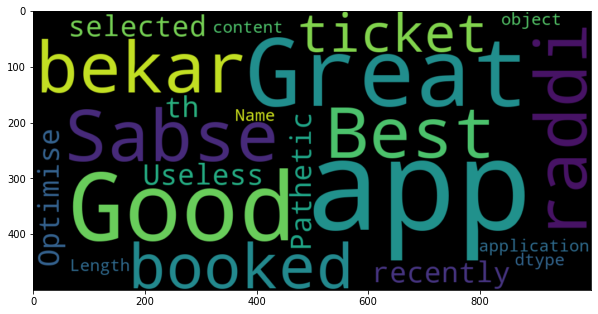

In [144]:
plt.figure(figsize=(10,10))
reviews=str(df_review['content'])
WC=WordCloud(width=1000,height=500,max_words=500,min_font_size=5)
words=WC.generate(reviews)
plt.imshow(words,interpolation='bilinear')
plt.show()

# LSTM Model 

In [108]:
class LSTM_Model:

    def __init__(self,input_shape:int,num_classes:int,hidden_units:int,units:int,vocabulary):

        self.input_shape=input_shape
        self.num_classes=num_classes
        self.hidden_units=hidden_units 


    def create_model(self,summary=None):

        input_layer=Input(shape=self.input_shape)
        embed=Embedding(vocabulary+1,50)(input_layer)
        lstm1=LSTM(self.hidden_units,return_sequences=True)(embed)
        lstm2=LSTM(self.hidden_units)(lstm1)
        output_layer=Dense(1,activation='sigmoid')(lstm2)
        model = Model(inputs=input_layer, outputs=output_layer)
        
        if summary:
            print(model.summary())
        return model

def train_model(model,params,checkpoint_CB):

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

    learning_rate=params['learning_rate']
    max_epochs=params['max_epochs']
    batch_size=params['batch_size']
    clip_value=params['clip_value']

    optimizer = Adam(learning_rate=learning_rate, clipvalue=clip_value)
    model_checkpoint=checkpoint_CB
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    history = model.fit(X_train, Y_train, epochs=max_epochs, batch_size=batch_size,
                    validation_data=(X_test, Y_test), callbacks=[early_stopping, model_checkpoint])
    return history               


In [109]:
# Define hyperparameters
learning_rate = 0.001
max_epochs = 10
batch_size = 64
clip_value = 1.0  # Gradient clipping threshold
params={
    'learning_rate':0.001,
    'max_epochs':10,
    'batch_size':64,
    'clip_value':1.0
}
checkpoint_callback = ModelCheckpoint(
    filepath='best_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)
optimizer = Adam(learning_rate=learning_rate, clipvalue=clip_value)

In [111]:
model=LSTM_Model(input_shape=X_train.shape[1],num_classes=2,hidden_units=128,units=2,vocabulary=vocabulary)
model_=model.create_model(summary=True)

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 500)]             0         
                                                                 
 embedding_11 (Embedding)    (None, 500, 50)           200050    
                                                                 
 lstm_20 (LSTM)              (None, 500, 128)          91648     
                                                                 
 lstm_21 (LSTM)              (None, 128)               131584    
                                                                 
 dense_20 (Dense)            (None, 1)                 129       
                                                                 
Total params: 423,411
Trainable params: 423,411
Non-trainable params: 0
_________________________________________________________________
None


In [112]:
train_model(model_,params,checkpoint_callback )

Epoch 1/10
55/55 [==============================] - ETA: 0s - loss: 0.5687 - accuracy: 0.7194
Epoch 1: val_accuracy improved from -inf to 0.76467, saving model to best_model.h5
55/55 [==============================] - 123s 2s/step - loss: 0.5687 - accuracy: 0.7194 - val_loss: 0.4797 - val_accuracy: 0.7647
Epoch 2/10
55/55 [==============================] - ETA: 0s - loss: 0.3603 - accuracy: 0.8500
Epoch 2: val_accuracy improved from 0.76467 to 0.86200, saving model to best_model.h5
55/55 [==============================] - 118s 2s/step - loss: 0.3603 - accuracy: 0.8500 - val_loss: 0.3691 - val_accuracy: 0.8620
Epoch 3/10
55/55 [==============================] - ETA: 0s - loss: 0.2402 - accuracy: 0.9143
Epoch 3: val_accuracy improved from 0.86200 to 0.86267, saving model to best_model.h5
55/55 [==============================] - 117s 2s/step - loss: 0.2402 - accuracy: 0.9143 - val_loss: 0.3441 - val_accuracy: 0.8627
Epoch 4/10
55/55 [==============================] - ETA: 0s - loss: 0.191

47/47 [==============================] - 11s 186ms/step


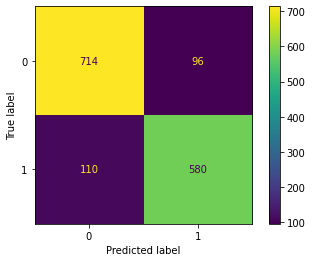

In [151]:
preds_LSTM_binary=model_.predict(X_test)
preds_LSTM_binary[preds_LSTM_binary>=0.5]=1
preds_LSTM_binary[preds_LSTM_binary<0.5]=0
cm=confusion_matrix(Y_test,preds_LSTM_binary)
disp=ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

F1_SCORE

In [152]:
f1_score(Y_test,preds_LSTM_binary)

0.8491947291361641

 Saving Tokenizer

In [118]:
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tk, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('tokenizer.pickle', 'rb') as handle:
    loaded_tokenizer = pickle.load(handle)

# Generating predictions live

In [146]:
def predict_review_sentiment(review_cur,tk,model):
    pat = r'[^a-zA-z0-9]'
    review_cur=re.sub(pat,' ',review_cur)
    review_cur=review_cur.lower()
    review_cur=review_cur.split()
    review_cur=[ps.stem(word) for word in review_cur if word not in stopwords.words('english')]
    review_cur=' '.join(review_cur)
    review=[]
    sentence_len=500
    review.append(review_cur)
    tokenized_review=pad_sequences(
    tk.texts_to_sequences(review),
    maxlen=sentence_len,
    padding="pre"
    )
    pred=model(tokenized_review)
    
    pred=tf.squeeze(pred)
    if pred>=0.5:
        pred=1
    else:
        pred=0
    return pred

while True:
    print("\n")
    print("Enter your review...")
    review=input()
    print(review)
    if review== "STOP":
        break
    live_prediction=predict_review_sentiment(review,loaded_tokenizer,model_)
    if live_prediction==1:
         print('Thats a positive review...')
    else:
         print('That sounds you are upset with the App')
    



Enter your review...
This is a nice app
Thats a positive review...


Enter your review...
This app is incredible !
That sounds you are upset with the App


Enter your review...
This app is very poor performing
That sounds you are upset with the App


Enter your review...
Worst app ever
That sounds you are upset with the App


Enter your review...
STOP
